In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from operators import dynamical_hamiltonian, boson_ops, qubit_ops
from correlations import get_g1_row, g1_matrix
from evolution import solve_dynamics
import pypulse
from scipy.interpolate import RectBivariateSpline
import numpy as np

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to mtch 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

In [3]:
cavity_dim  = 20

g_real = 2*jnp.pi*10.0e6  # 10 MHz

g_sim = g_real/g_real
delta_c = 0/g_real
delta_e = 0/g_real
kappa = 0.2
gamma = 0.01

# Pulse Definition

In [4]:
f_0 = 0.0
pulse_fwhm = 5
pulse_area = jnp.pi
pulse_type = pypulse.pulses.gaussian

f_lim = pypulse.set_frequency_limits(f_0, pulse_fwhm, pulse_type, pulse_fwhm / 10)
f = jnp.linspace(-f_lim, f_lim, 5000) + f_0
frequency_pulse = pypulse.frequency_field(f, f_0, pulse_fwhm, pulse_area, pulse_type)

t_lim = pypulse.set_time_limits(f, frequency_pulse, 0.1 / pulse_fwhm)
t_data = jnp.linspace(-t_lim, t_lim, 5000)
temporal_pulse = pypulse.time_field(f, frequency_pulse, t_data)

In [5]:
def drive(t):
    interpolated_value = jnp.interp(t, t_data, temporal_pulse)
    return jnp.abs(interpolated_value)

In [6]:
t_max = 2*jnp.max(t_data)
t_array = jnp.linspace(-t_max, 30*t_max, 500)

psi_c_vac = jnp.zeros(cavity_dim).at[0].set(1.0)
psi_q_gnd = jnp.array([1.0, 0.0])

psi_0 = jnp.kron(psi_c_vac, psi_q_gnd)
rho_initial = jnp.outer(psi_0, jnp.conj(psi_0))

H_t_func = dynamical_hamiltonian(cavity_dim, delta_c, delta_e, g_sim)

a, adag, n_op = boson_ops(cavity_dim)
sigma_m, sigma_p, sigma_e = qubit_ops()

I_c = jnp.eye(cavity_dim)
I_a = jnp.eye(2)

sigma_m_full = jnp.kron(I_c, sigma_m)
sigma_p_full = jnp.kron(I_c, sigma_p)
a_full = jnp.kron(a, I_a)
adag_full = jnp.kron(adag, I_a)

L1 = jnp.sqrt(kappa)*a_full
L2 = jnp.sqrt(gamma)*sigma_m_full

L_ops = [L1, L2]

In [7]:
rho_all_t = solve_dynamics(rho_initial, t_array, H_t_func, drive, L_ops)

/home/juardilag/miniconda3/envs/FemtoPy/lib/python3.11/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


/home/juardilag/miniconda3/envs/FemtoPy/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/juardilag/miniconda3/envs/FemtoPy/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


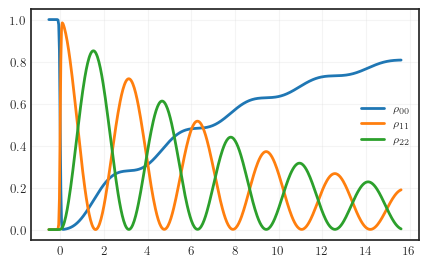

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(t_array, rho_all_t[:, 0, 0], label=r'$\rho_{00}$', linewidth = 2)
plt.plot(t_array, rho_all_t[:, 1, 1], label=r'$\rho_{11}$', linewidth = 2)
plt.plot(t_array, rho_all_t[:, 2, 2], label=r'$\rho_{22}$', linewidth = 2)
plt.legend()
plt.grid(alpha = 0.2)
plt.show()

# G1 Correlation Function

In [9]:
from correlations import g1_matrix

In [10]:
tau_array_pos =  jnp.linspace(0, 20, 500)
tau_array_neg = jnp.flip(-tau_array_pos)[1:]
tau_array_full = jnp.concatenate([tau_array_neg, tau_array_pos])

G1_matrix = g1_matrix(
    rho_t_array = rho_all_t,
    t_array = t_array,
    a_L = a_full,
    adag_L = adag_full,
    tau_array_pos = tau_array_pos,
    tau_array_neg = tau_array_neg,
    L_ops = L_ops,
    H_t_func = H_t_func,
    E_func = drive
)

/home/juardilag/miniconda3/envs/FemtoPy/lib/python3.11/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


# Correlation Function

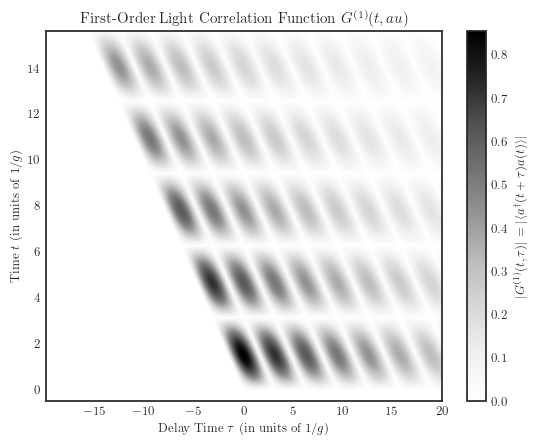

In [11]:
G1_abs = jnp.abs(G1_matrix)

plt.pcolormesh(tau_array_full, t_array, G1_abs, shading='gouraud')

plt.colorbar(label=r"$|G^{(1)}(t, \tau)| = |\langle a^\dagger(t+\tau) a(t) \rangle|$")
plt.title("First-Order Light Correlation Function $G^{(1)}(t, \tau)$")
plt.xlabel(r"Delay Time $\tau$ (in units of $1/g$)")
plt.ylabel(r"Time $t$ (in units of $1/g$)")
plt.show()